In [3]:
import os
import cv2
import shutil
import random
import numpy as np
import glob
import pathlib 
import random
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt 
import hashlib

In [7]:
#Create folders for final dataset and two categories (irrelevant images and breast ultrasound images)
os.mkdir("final_dataset3")
train = os.path.join("final_dataset3", "train")
val = os.path.join("final_dataset3", "val")
test = os.path.join("final_dataset3", "test")
os.mkdir(train)
os.mkdir(val)
os.mkdir(test)

In [8]:
normal_train = './final_dataset3/train/normal'
normal_val = './final_dataset3/val/normal'
normal_test = './final_dataset3/test/normal'

normal_images_train = glob.glob(os.path.join("./Dataset_BUSI_with_GT/train/normal/", "*.png"))
normal_images_val = glob.glob(os.path.join("./Dataset_BUSI_with_GT/val/normal/", "*.png"))
normal_images_test = glob.glob(os.path.join("./Dataset_BUSI_with_GT/test/normal/", "*.png"))

for image in normal_images_train:
    shutil.copy(image, normal_train)
for image in normal_images_val:
    shutil.copy(image, normal_val)
for image in normal_images_test:
    shutil.copy(image, normal_test)

In [19]:
benign_images_train = glob.glob(os.path.join("./Dataset_BUSI_with_GT/train/benign/", "*.png"))
malignant_images_train = glob.glob(os.path.join("./Dataset_BUSI_with_GT/train/malignant/", "*.png"))

benign_images_val = glob.glob(os.path.join("./Dataset_BUSI_with_GT/val/benign/", "*.png"))
malignant_images_val = glob.glob(os.path.join("./Dataset_BUSI_with_GT/val/malignant/", "*.png"))

benign_images_test = glob.glob(os.path.join("./Dataset_BUSI_with_GT/test/benign/", "*.png"))
malignant_images_test = glob.glob(os.path.join("./Dataset_BUSI_with_GT/test/malignant/", "*.png"))

benign_images_train_half = random.sample(benign_images_train, 402)
malignant_images_train_half = random.sample(malignant_images_train, 402)

benign_images_val_half = random.sample(benign_images_val, 86)
malignant_images_val_half = random.sample(malignant_images_val, 86)

benign_images_test_half = random.sample(benign_images_test, 86)
malignant_images_test_half = random.sample(malignant_images_test, 86)

for image in benign_images_train_half:
    shutil.copy(image, './final_dataset3/train/tumor')
for image in malignant_images_train_half:
    shutil.copy(image, './final_dataset3/train/tumor')
    
for image in benign_images_val_half:
    shutil.copy(image, './final_dataset3/val/tumor')
for image in malignant_images_val_half:
    shutil.copy(image, './final_dataset3/val/tumor')

for image in benign_images_test_half:
    shutil.copy(image, './final_dataset3/test/tumor')
for image in malignant_images_test_half:
    shutil.copy(image, './final_dataset3/test/tumor')

172


In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import seaborn as sns

2024-11-16 11:38:14.704651: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 11:38:14.704687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 11:38:14.706161: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 11:38:14.714103: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [14]:
base_dir = './final_dataset3'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [15]:
#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Train,Val and Test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(331, 331),
    batch_size=32,
    class_mode='binary',
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(331, 331),
    batch_size=32,
    class_mode='binary',
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(331, 331),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
)

Found 1606 images belonging to 2 classes.
Found 343 images belonging to 2 classes.
Found 345 images belonging to 2 classes.


Deleting: ./final_dataset3/.ipynb_checkpoints
Deleting: ./final_dataset3/train/.ipynb_checkpoints
Deleting: ./final_dataset3/test/.ipynb_checkpoints
Deleting: ./final_dataset3/test/normal/.ipynb_checkpoints
Deleting: ./final_dataset3/val/.ipynb_checkpoints


In [16]:
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(331, 331, 3))

In [17]:
#Final layers set
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

In [18]:
model = Model(inputs=base_model.input, outputs=output_layer)

In [19]:
#Freeze early layers
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/12
51/51 [==============================] - 73s 685ms/step - loss: 0.4433 - accuracy: 0.8007 - val_loss: 0.2979 - val_accuracy: 0.8688
Epoch 2/12
51/51 [==============================] - 25s 477ms/step - loss: 0.2034 - accuracy: 0.9166 - val_loss: 0.2446 - val_accuracy: 0.8980
Epoch 3/12
51/51 [==============================] - 24s 473ms/step - loss: 0.1352 - accuracy: 0.9502 - val_loss: 0.1899 - val_accuracy: 0.9125
Epoch 4/12
51/51 [==============================] - 24s 469ms/step - loss: 0.0839 - accuracy: 0.9720 - val_loss: 0.1415 - val_accuracy: 0.9417
Epoch 5/12
51/51 [==============================] - 24s 473ms/step - loss: 0.0542 - accuracy: 0.9875 - val_loss: 0.1560 - val_accuracy: 0.9329
Epoch 6/12
51/51 [==============================] - 24s 477ms/step - loss: 0.0551 - accuracy: 0.9826 - val_loss: 0.1504 - val_accuracy: 0.9388
Epoch 7/12
51/51 [==============================] - 24s 468ms/step - loss: 0.0284 - accuracy: 0.9963 - val_loss: 0.1786 - val_accuracy: 0.9300

In [21]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

11/11 [==============================] - 5s 478ms/step - loss: 0.1189 - accuracy: 0.9652
Test accuracy: 0.9652174115180969


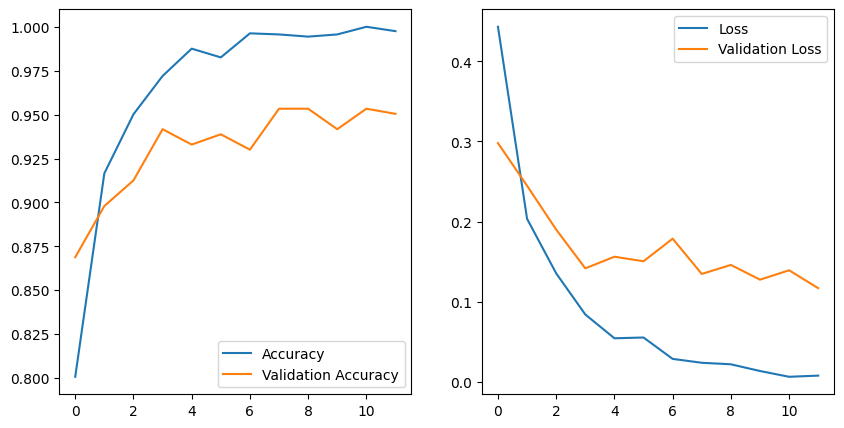

In [22]:
#Accuracy,Val accuracy, loss and val loss graphs
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [23]:
predictions = model.predict(test_generator)
binary_predictions = (predictions > 0.5).astype(int).flatten()

true_labels = test_generator.classes

11/11 [==============================] - 15s 395ms/step


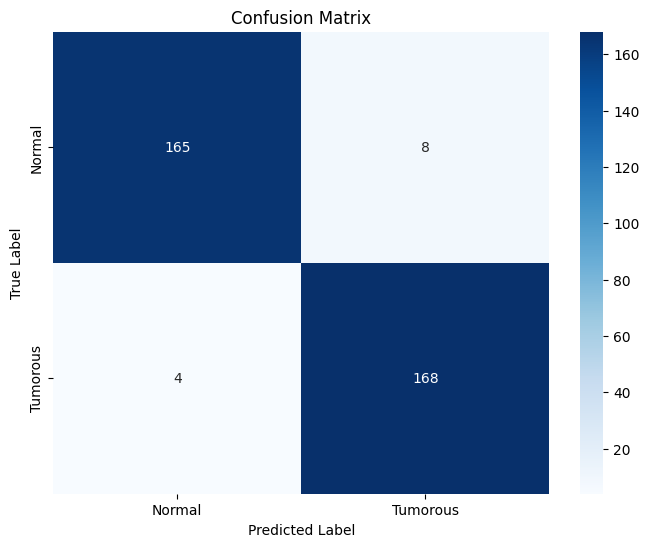

In [24]:
#Confussion matrix
cm = confusion_matrix(true_labels, binary_predictions)
classes = ['Normal','Tumorous']
#Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [25]:
model.save('NASNet_2class_mid')

INFO:tensorflow:Assets written to: NASNet_2class_mid/assets


INFO:tensorflow:Assets written to: NASNet_2class_mid/assets
